In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [78]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [79]:
data_train.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
811,812,0,3,"Lester, Mr. James",male,39.0,0,0,A/4 48871,24.1500,NaN,S
66,67,1,2,"Nye, Mrs. (Elizabeth Ramell)",female,29.0,0,0,C.A. 29395,10.5000,F33,S
393,394,1,1,"Newell, Miss. Marjorie",female,23.0,1,0,35273,113.2750,D36,C
55,56,1,1,"Woolner, Mr. Hugh",male,NaN,0,0,19947,35.5000,C52,S
351,352,0,1,"Williams-Lambert, Mr. Fletcher Fellows",male,NaN,0,0,113510,35.0000,C128,S
504,505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,S
749,750,0,3,"Connaghton, Mr. Michael",male,31.0,0,0,335097,7.7500,NaN,Q
730,731,1,1,"Allen, Miss. Elisabeth Walton",female,29.0,0,0,24160,211.3375,B5,S
60,61,0,3,"Sirayanian, Mr. Orsen",male,22.0,0,0,2669,7.2292,NaN,C
738,739,0,3,"Ivanoff, Mr. Kanio",male,NaN,0,0,349201,7.8958,NaN,S


In [ ]:
Обробити дані для подальшого використання у кластеризації (вирішити проблему з missing data, закодувати змінні).

In [80]:
missing_values = data_train.isnull().sum()
print(missing_values) 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [91]:
data_train[data_train.duplicated()] 
# дублікатів немає

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [103]:
# будемо заміняти відсутні значення в стовпці "Age", спираючись на кількість дітей у цього пасажира (поле "Parch")
# так як наявність дітей, скоріш за все, свідчить про більший вік

# створимо новий стовпець, що показує, чи є у пасажира діти
data_train['Has_children'] = np.where(data_train['Parch'] > 0, 1, 0)

# розрахуємо середній вік для кожної групи з дітьми та без дітей
mean_age_children = data_train[data_train['Has_children'] == 1]['Age'].mean()
mean_age_no_children = data_train[data_train['Has_children'] == 0]['Age'].mean()

# функція для заміни відсутніх значень віку залежно від наявності дітей
def impute_age(row):
    if pd.isnull(row['Age']):
        if row['Has_children'] == 1:
            return mean_age_children
        else:
            return mean_age_no_children
    else:
        return row['Age']

# замінемо відсутні значень віку за допомогою нової функції
data_train['Age'] = data_train.apply(impute_age, axis=1)

# видяляємо стовпець
data_train.drop('Has_children', axis=1, inplace=True)

In [107]:
# стовпець "Embarked" вказує на порт посадки пасажира (C = Cherbourg, Q = Queenstown, S = Southampton) 
# оскільки в ньому лише два відсутніх значення, можна замінити їх на найбільш поширений порт посадки серед усіх пасажирів. 
most_common_port = data_train['Embarked'].mode()[0]
data_train['Embarked'] = data_train['Embarked'].fillna(most_common_port)

In [108]:
# стовпець "Cabin" містить багато відсутніх значень (687 із 891), тому його доцільніше просто видалити
data_train.drop('Cabin', axis=1, inplace=True)

In [109]:
missing_values = data_train.isnull().sum()
print(missing_values) 

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [110]:
data_train.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
403,404,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28.000000,1,0,STON/O2. 3101279,15.8500,S
178,179,0,2,"Hale, Mr. Reginald",male,30.000000,0,0,250653,13.0000,S
876,877,0,3,"Gustafsson, Mr. Alfred Ossian",male,20.000000,0,0,7534,9.8458,S
825,826,0,3,"Flynn, Mr. John",male,32.178503,0,0,368323,6.9500,Q
121,122,0,3,"Moore, Mr. Leonard Charles",male,32.178503,0,0,A4. 54510,8.0500,S


In [112]:
from sklearn.preprocessing import LabelEncoder

In [115]:
# закодуємо категоріальні змінні "Sex" і "Embarked" у числові формати, щоб наш алгоритм кластеризації міг працювати з цими даними
label_encoder_sex = LabelEncoder()
label_encoder_embarked = LabelEncoder()

data_train['Sex'] = label_encoder_sex.fit_transform(data_train['Sex'])
data_train['Embarked'] = label_encoder_embarked.fit_transform(data_train['Embarked'])

In [116]:
# стовпці з іменами пасажирів і номерами квитків також слід видалити, 
# оскільки вони не несуть корисної інформації для кластеризації
# і не можуть бути коректно перетворені у числовий формат.
data_train.drop('Name', axis=1, inplace=True)
data_train.drop('Ticket', axis=1, inplace=True)

In [154]:
data_train.sample(5)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,cluster_label
621,622,1,1,1,42.000000,1,0,52.5542,2,2
248,249,1,1,1,37.000000,1,1,52.5542,2,1
418,419,0,2,1,30.000000,0,0,13.0000,2,1
522,523,0,3,1,32.178503,0,0,7.2250,0,1
171,172,0,3,1,4.000000,4,1,29.1250,1,0


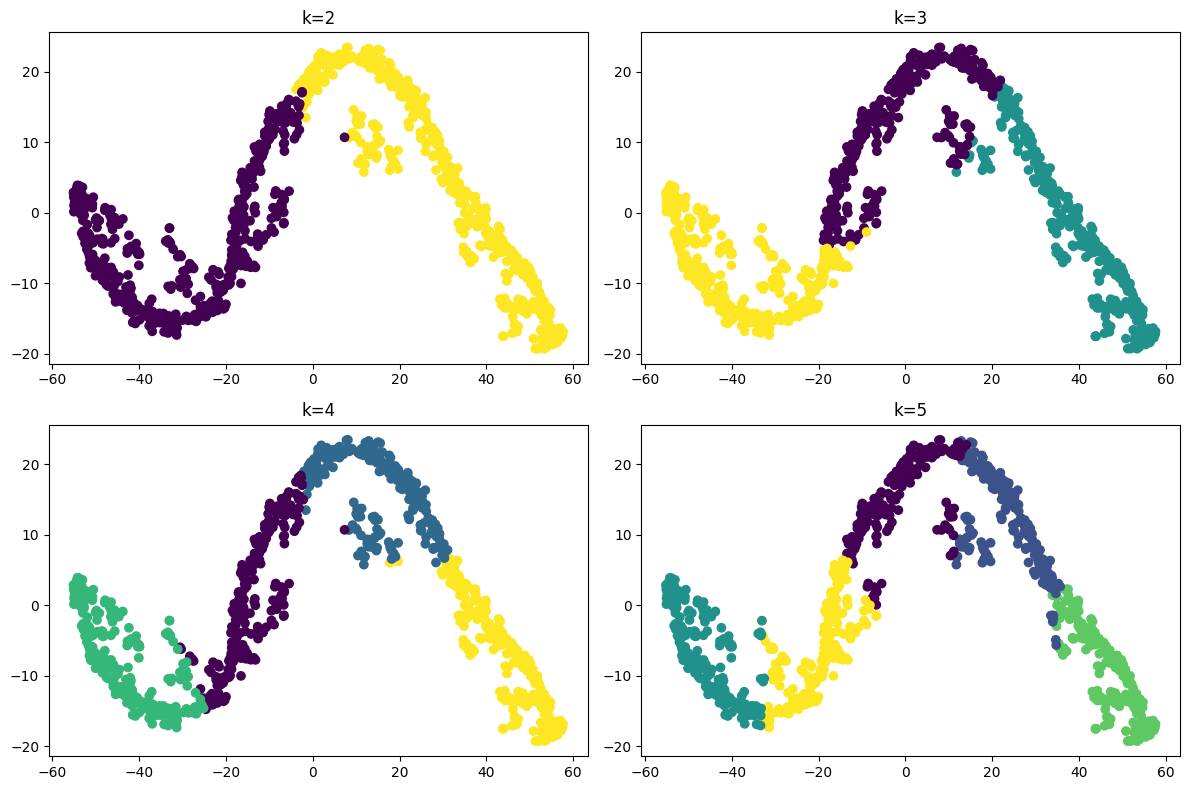

In [352]:
# K-Means метод
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# cписок значень k (кількість кластерів) для методу K-Means
k_values = range(2, 6)
cluster_labels_list = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    cluster_labels = kmeans.fit_predict(data_train)
    cluster_labels_list.append(cluster_labels)

# зменшемо розмірність даних за допомогою t-SNE
tsne = TSNE(n_components=2, random_state=0)
data_tsne = tsne.fit_transform(data_train)

# побудова графіків для кожного значення k
plt.figure(figsize=(12, 8))

for i, k in enumerate(k_values, 1):
    cluster_labels = cluster_labels_list[i-1]
    plt.subplot(2, 2, i)
    plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=cluster_labels, cmap='viridis')
    plt.title(f'k={k}')

plt.tight_layout()
plt.show()

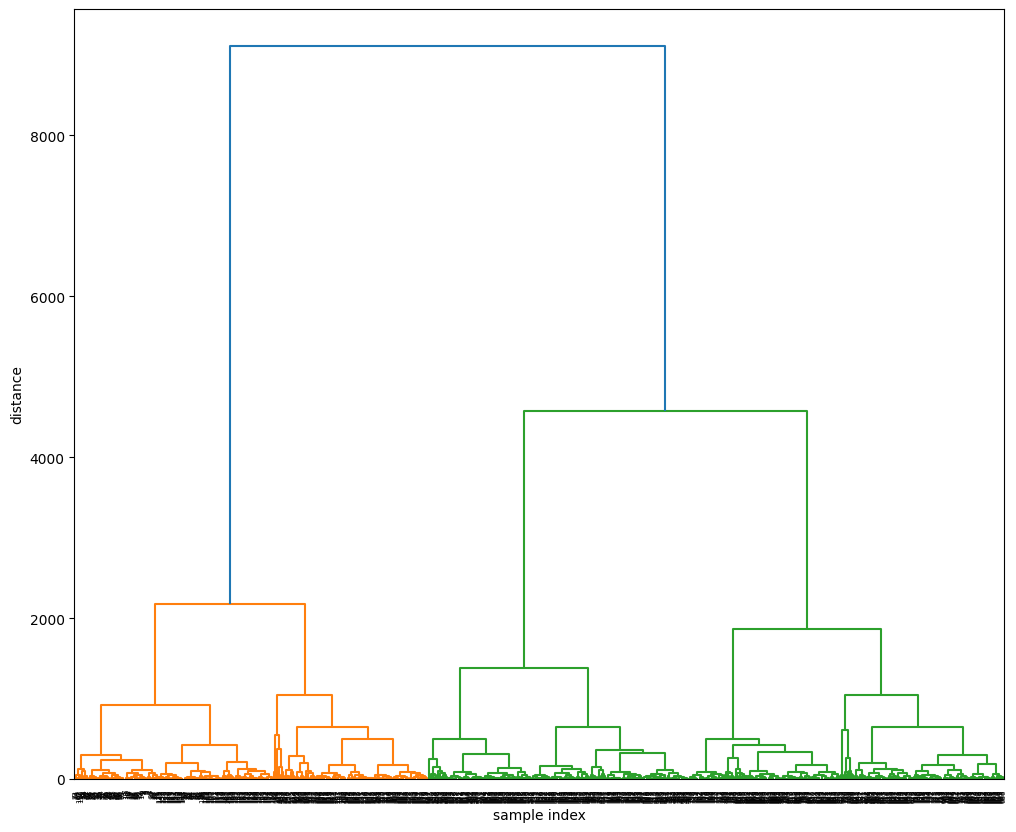

In [388]:
# Ієрархічна кластеризація (ward)
from scipy.cluster.hierarchy import dendrogram, linkage

D_ward = linkage(data_train, method='ward')

# побудуємо дендрограми
plt.figure(figsize=(12, 10))
dendrogram(D_ward)
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

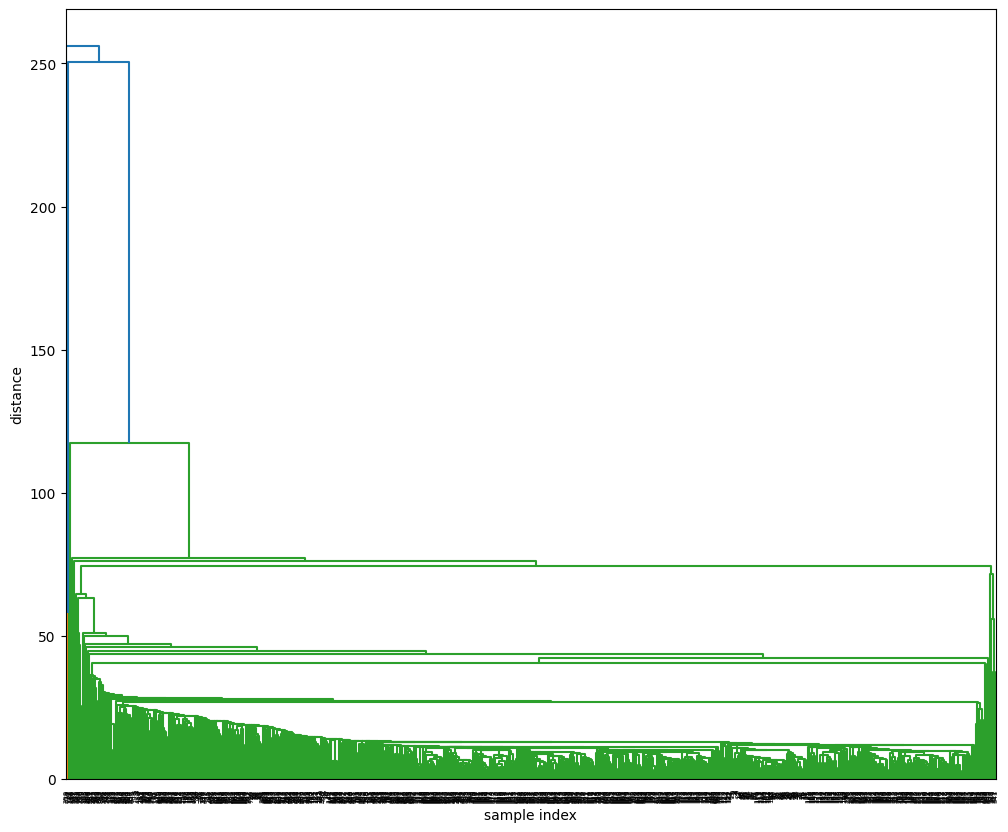

In [397]:
# Ієрархічна кластеризація (single)
D_single = linkage(data_train, method='single')

# побудуємо дендрограми
plt.figure(figsize=(12, 10))
dendrogram(D_single)
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

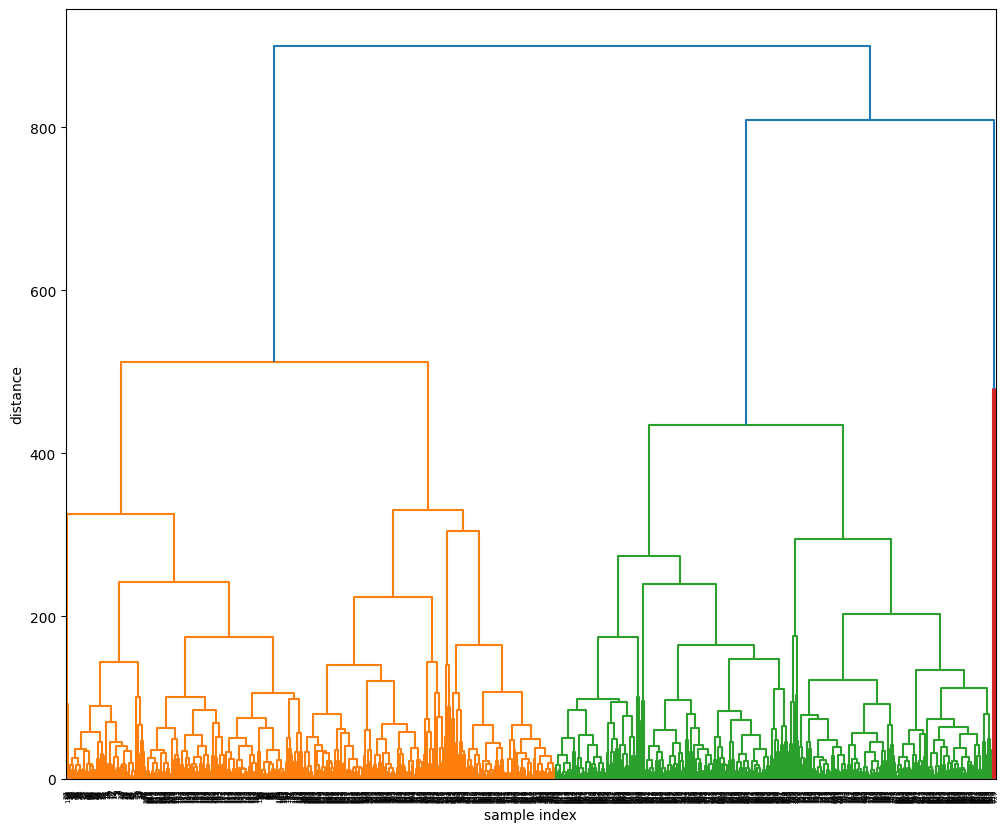

In [398]:
# Ієрархічна кластеризація (complete)
D_complete = linkage(data_train, method='complete')

# побудуємо дендрограми
plt.figure(figsize=(12, 10))
dendrogram(D_complete)
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

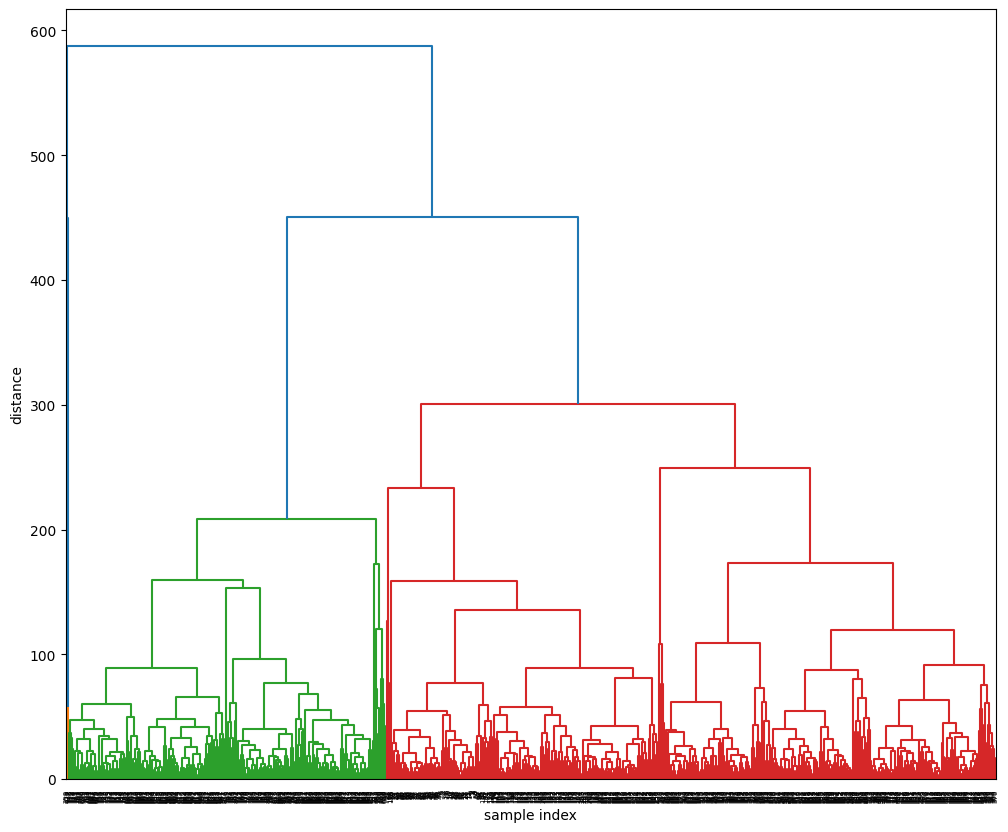

In [405]:
# Ієрархічна кластеризація (average)
D_average = linkage(data_train, method='average')

# побудуємо дендрограми
plt.figure(figsize=(12, 10))
dendrogram(D_average)
plt.xlabel('sample index')
plt.ylabel('distance')
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_train)

# список значень eps, для яких будемо будувати графіки
eps_values = [0.1, 0.5, 1.0, 1.5]

plt.figure(figsize=(12, 8))

for i, eps in enumerate(eps_values, 1):
    dbscan = DBSCAN(eps=eps, min_samples=5)
    cluster_labels = dbscan.fit_predict(data_scaled)
    
    # зменшуємо розмірність даниз з допомогою PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data_scaled)
    
    plt.subplot(2, 2, i)
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=cluster_labels, cmap='viridis')
    plt.title(f'eps={eps}')

plt.tight_layout()
plt.show()
